In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium.utils.env_checker import check_env
from gymnasium.envs.registration import register
from stable_baselines3 import PPO

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.evaluation import evaluate_policy
import wandb
from wandb.integration.sb3 import WandbCallback
from sine_env import SineEnv

In [8]:
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 1_000_000,
    "env_name": "SineWave-v0",
    "amplitude_min": 1,
    "amplitude_max": 10,
    "frequency_min": 10,
    "frequency_max": 100,
    "lookback": 3,
    "count": 1000
}

In [9]:
# METRICS
run = wandb.init(
    project="sinewave",
    notes="v0.2",
    config=config,
    sync_tensorboard=True,
    # monitor_gym=True,
)

/usr/local/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SineEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.show to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.show` for environment variables or `env.get_wrapper_attr('show')` that will search the reminding wrappers.
  logger.warn(


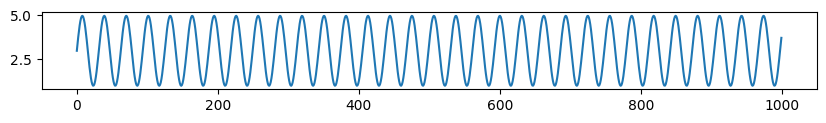

In [10]:
# TRAINING ENV
register(
    id='SineEnv-v0', 
    entry_point='sine_env:SineEnv',
    nondeterministic=False,
    # reward_threshold=
    # autoreset=
)
env = gym.make('SineEnv-v0', config=config)
env.show()

In [11]:
# CHECK ENV
check_env(env.unwrapped)  # Great for catching issues
observation, _ = env.reset()
for _ in range(5):
    action = env.action_space.sample()
    observation, reward, _, _, _ = env.step(action)
    print(observation)

[0.         0.03566931 0.03378156]
[0.03566931 0.03378156 0.03141443]
[0.03378156 0.03141443 0.02864984]
[0.03141443 0.02864984 0.02556133]
[0.02864984 0.02556133 0.02221366]


In [12]:
# TRAIN
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./logs")
model.learn(
    total_timesteps=config["total_timesteps"], 
    callback=WandbCallback()
)
wandb.finish()

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.8     |
|    ep_rew_mean     | -10.4    |
| time/              |          |
|    fps             | 481      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 54.5        |
|    ep_rew_mean          | -9.82       |
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015147354 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2       

KeyboardInterrupt: 

In [16]:
# TEST   
env = gym.make('SineEnv-v0', config=config)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

/usr/local/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 917.25 +/- 27.85
